In [13]:
!pip install datasets
!pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    DistilBertConfig,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset



# Distillation using Masked Language Modelling

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    DataCollatorForLanguageModeling,
    AutoModelForSequenceClassification,
)
import torch.optim as opt
from datasets import load_dataset
from tqdm import tqdm
import torch.nn.functional as F

In [22]:
# Config
TEACHER_MODEL = "bert-base-uncased"
STUDENT_MODEL = "distilbert-base-uncased"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
LR = 5e-5
EPOCHS = 3
MAX_LEN = 128
MLM_PROB = 0.15

In [ ]:
# Load dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL)

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=MAX_LEN)

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Data collator will mask tokens for us
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=MLM_PROB)
dataloader = DataLoader(tokenized_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

In [ ]:
# Load teacher and student
teacher = AutoModelForMaskedLM.from_pretrained(TEACHER_MODEL).to(DEVICE)
student = AutoModelForMaskedLM.from_pretrained(STUDENT_MODEL).to(DEVICE)
teacher.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
def copy_every_other_layer(student, teacher):
    """
    Copy every other teacher layer into the student.
    Assumes student has half as many encoder layers as teacher.
    """
    teacher_layers = teacher.bert.encoder.layer
    student_layers = student.distilbert.transformer.layer

    # Copy every other teacher layer into student
    for i, layer in enumerate(student_layers):
        teacher_layer = teacher_layers[i * 2]
        layer.load_state_dict(teacher_layer.state_dict(), strict=False)

copy_every_other_layer(student, teacher)

In [ ]:
print(type(student))


<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForMaskedLM'>


In [ ]:
from torch.nn import CosineEmbeddingLoss

# Optional: distillation via KL divergence
def distill_loss(student_logits,
                 teacher_logits,
                 student_hidden,
                 teacher_hidden,
                 labels,
                 temperature=2.0,
                 alpha=0.5,
                 beta=0.5,
                 gamma=1.0):

    cosine_loss_fn = CosineEmbeddingLoss()

    # Only compute loss on masked tokens
    mask = labels != -100
    if mask.sum() == 0:
      print("mask sum is 0")
      return torch.tensor(0.0, device=student_logits.device, requires_grad=True)

    #### Masked LM Loss ####
    ce_loss = F.cross_entropy(student_logits.view(-1, student_logits.size(-1)), labels.view(-1), ignore_index=-100)

    student_logits = torch.clamp(student_logits, -1e4, 1e4)
    teacher_logits = torch.clamp(teacher_logits, -1e4, 1e4)

    # KL divergence between softened predictions
    student_probs = F.log_softmax(student_logits / temperature, dim=-1)
    teacher_probs = F.softmax(teacher_logits / temperature, dim=-1)

    kl_loss = F.kl_div(
        student_probs,
        teacher_probs,
        reduction="batchmean"
    ) * (temperature ** 2)

    # Cosine embedding loss on hidden states
    # Cosine embedding loss between intermediate hidden states
    losses = []
    teacher_layers = teacher_hidden[1::2]  # take every 2nd layer starting from index 1
    student_layers = student_hidden[1:]    # skip the student input embedding layer

    for t, s in zip(teacher_layers, student_layers):
        # Flatten hidden state in vectors of HIDDEN_STATE_SIZE for every token
        # in the batch (B, SEQ_LEN, HIDDEN_STATE_SIZE) -> (B x SEQ_LEN, HIDDEN_STATE_SIZE)
        t_flat = t.reshape(-1, t.size(-1))
        s_flat = s.reshape(-1, s.size(-1))

        # Create a tensor of ones (B x SEQ_LEN) as the target cosine similarity
        # between teacher and student hidden states
        target = torch.ones(t_flat.size(0)).to(t.device)
        losses.append(cosine_loss_fn(s_flat, t_flat, target))

    cos_loss = torch.stack(losses).mean()

    return alpha * ce_loss + beta * kl_loss + gamma * cos_loss

In [ ]:
optimizer = opt.AdamW(student.parameters(), lr=LR)

In [ ]:
# Training loop
for epoch in range(EPOCHS):
    student.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        with torch.no_grad():
            teacher_outputs = teacher(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True
            )
            teacher_logits = teacher_outputs.logits
            teacher_hidden_states = teacher_outputs.hidden_states

        student_outputs = student(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        student_logits = student_outputs.logits
        student_hidden_states = student_outputs.hidden_states
        loss = distill_loss(student_logits, teacher_logits,
                            student_hidden_states, teacher_hidden_states,
                            labels,
                            temperature=2.0, alpha=0.5, beta=0.5, gamma=1.0)

        if torch.isnan(loss) or torch.isinf(loss):
            print("Skipping batch due to NaN/Inf loss")
            continue

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")



student.save_pretrained("distilled-bert-small-cola-wikitext-used")
tokenizer.save_pretrained("distilled-bert-small-cola-wikitext-used")

save_path = "/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/distilled-bert-small-wikitext"

student.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

Epoch 1:   9%|▉         | 426/4590 [01:45<14:12,  4.88it/s]

mask sum is 0


Epoch 1:  15%|█▍        | 685/4590 [02:49<13:16,  4.90it/s]

mask sum is 0


Epoch 1:  73%|███████▎  | 3370/4590 [13:49<04:11,  4.84it/s]

mask sum is 0


Epoch 1: 100%|██████████| 4590/4590 [18:49<00:00,  4.07it/s]


Epoch 1 | Loss: 36.2907


Epoch 2:   7%|▋         | 320/4590 [01:18<14:51,  4.79it/s]

mask sum is 0


Epoch 2:  40%|███▉      | 1820/4590 [07:27<09:25,  4.90it/s]

mask sum is 0


Epoch 2:  40%|████      | 1838/4590 [07:31<09:21,  4.90it/s]

mask sum is 0


Epoch 2:  40%|████      | 1845/4590 [07:32<09:15,  4.95it/s]

mask sum is 0


Epoch 2:  41%|████      | 1870/4590 [07:38<09:17,  4.88it/s]

mask sum is 0


Epoch 2:  58%|█████▊    | 2665/4590 [10:54<06:35,  4.87it/s]

mask sum is 0


Epoch 2:  62%|██████▏   | 2848/4590 [11:38<05:54,  4.92it/s]

mask sum is 0


Epoch 2:  67%|██████▋   | 3090/4590 [12:38<05:06,  4.90it/s]

mask sum is 0


Epoch 2:  83%|████████▎ | 3798/4590 [15:31<02:41,  4.90it/s]

mask sum is 0


Epoch 2: 100%|██████████| 4590/4590 [18:46<00:00,  4.07it/s]


Epoch 2 | Loss: 32.5126


Epoch 3:   1%|          | 39/4590 [00:09<15:32,  4.88it/s]

mask sum is 0


Epoch 3:   4%|▍         | 204/4590 [00:49<14:53,  4.91it/s]

mask sum is 0


Epoch 3:  44%|████▍     | 2032/4590 [08:18<08:51,  4.81it/s]

mask sum is 0


Epoch 3:  81%|████████  | 3712/4590 [15:10<02:59,  4.89it/s]

mask sum is 0


Epoch 3:  97%|█████████▋| 4435/4590 [18:07<00:31,  4.89it/s]

mask sum is 0


Epoch 3:  99%|█████████▊| 4526/4590 [18:29<00:13,  4.81it/s]

mask sum is 0


Epoch 3: 100%|██████████| 4590/4590 [18:45<00:00,  4.08it/s]


Epoch 3 | Loss: 31.0128


('/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/distilled-bert-small-wikitext/tokenizer_config.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/distilled-bert-small-wikitext/special_tokens_map.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/distilled-bert-small-wikitext/vocab.txt',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/distilled-bert-small-wikitext/added_tokens.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/distilled-bert-small-wikitext/tokenizer.json')

# Finetune for CoLA



In [ ]:
MODEL_PATH = "/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/distilled-bert-small-wikitext"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5

In [20]:
cola = load_dataset("glue", "cola")

model_path="/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/distilled-bert-small-wikitext"
tokenizer = AutoTokenizer.from_pretrained(model_path,local_files_only=True)

def preprocess(example):
    return tokenizer(example["sentence"], truncation=True, padding="max_length", max_length=256)

encoded_cola = cola.map(preprocess, batched=True)
encoded_cola.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer)
train_loader = DataLoader(encoded_cola["train"], shuffle=True, batch_size=BATCH_SIZE, collate_fn=data_collator)
test_loader = DataLoader(encoded_cola["validation"], batch_size=BATCH_SIZE, collate_fn=data_collator)

**Load the distilled student model and add a classification head to it.**

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=2).to(DEVICE)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/distilled-bert-small-wikitext and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_cola["train"],
    eval_dataset=encoded_cola["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

<ipython-input-39-2dda3a678844>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.491900,0.469300
2,0.325800,0.466360
3,0.244300,0.559534


TrainOutput(global_step=1605, training_loss=0.37957518902894494, metrics={'train_runtime': 569.191, 'train_samples_per_second': 45.069, 'train_steps_per_second': 2.82, 'total_flos': 1699093088861184.0, 'train_loss': 0.37957518902894494, 'epoch': 3.0})

In [ ]:
save_path = "/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/finetuned-distilled-cola"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/finetuned-distilled-cola/tokenizer_config.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/finetuned-distilled-cola/special_tokens_map.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/finetuned-distilled-cola/vocab.txt',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/finetuned-distilled-cola/added_tokens.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/finetuned-distilled-cola/tokenizer.json')

In [ ]:
# Load teacher model with classification head
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
).to(DEVICE)

teacher_training_args = TrainingArguments(
    output_dir="./results-teacher",
    eval_strategy="epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs-teacher",
    logging_steps=100,
    report_to="none"
)

teacher_trainer = Trainer(
    model=teacher_model,
    args=teacher_training_args,
    train_dataset=encoded_cola["train"],
    eval_dataset=encoded_cola["validation"],
    tokenizer=tokenizer,  # Use student tokenizer since it was already applied to data
    data_collator=data_collator,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-23-870346b75852>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  teacher_trainer = Trainer(


In [ ]:
# === Train the teacher ===
teacher_trainer.train()

# === Evaluate the teacher ===
teacher_trainer.evaluate()

Epoch,Training Loss,Validation Loss
1,0.434900,0.433967
2,0.250800,0.496302
3,0.195000,0.629981


{'eval_loss': 0.6299806833267212,
 'eval_runtime': 13.8454,
 'eval_samples_per_second': 75.332,
 'eval_steps_per_second': 4.767,
 'epoch': 3.0}

In [ ]:
teacher_finetuned_path = "/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/finetuned-bert-cola"
teacher_model.save_pretrained(teacher_finetuned_path)
tokenizer.save_pretrained(teacher_finetuned_path)

('/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/finetuned-bert-cola/tokenizer_config.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/finetuned-bert-cola/special_tokens_map.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/finetuned-bert-cola/vocab.txt',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/finetuned-bert-cola/added_tokens.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/finetuned-bert-cola/tokenizer.json')

# Comparison of both finetuned models

In [16]:
student_model_path = "/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/finetuned-distilled-cola"
teacher_model_path = "/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/finetuned-bert-cola"

In [17]:
import torch
from transformers import AutoModelForSequenceClassification
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
student = AutoModelForSequenceClassification.from_pretrained(student_model_path, local_files_only=True).to(DEVICE)
teacher = AutoModelForSequenceClassification.from_pretrained(teacher_model_path, local_files_only=True).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(student_model_path, local_files_only=True)

In [21]:
encoded_cola = cola.map(preprocess, batched=True)
encoded_cola.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

test_dataset = encoded_cola["validation"]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

In [23]:
def custom_collate(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

test_loader = DataLoader(encoded_cola["validation"], batch_size=BATCH_SIZE, collate_fn=custom_collate)


In [24]:
from tqdm import tqdm
# data_collator = DataCollatorWithPadding(tokenizer)
# test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=data_collator)

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return correct / total

# Evaluate
student_accuracy = evaluate(student, test_loader)
teacher_accuracy = evaluate(teacher, test_loader)

print(f"Student accuracy: {student_accuracy:.4f}\n")
print(f"Teacher accuracy: {teacher_accuracy:.4f}")


100%|██████████| 131/131 [00:14<00:00,  8.85it/s]

Student accuracy: 0.7958

Teacher accuracy: 0.8265


In [25]:
student_size = sum(p.numel() for p in student.parameters()) / 1e6
teacher_size = sum(p.numel() for p in teacher.parameters()) / 1e6

print(f"Student model size: {student_size:.2f}M parameters")
print(f"Teacher model size: {teacher_size:.2f}M parameters")

Student model size: 66.96M parameters
Teacher model size: 109.48M parameters


In [26]:
import os
import time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, matthews_corrcoef


def evaluate_model(model, dataloader, model_path=None):
    model.eval()
    preds = []
    labels = []
    start_time = time.time()

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            batch_labels = batch["labels"].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            preds.append(logits.argmax(dim=-1).cpu())
            labels.append(batch_labels.cpu())

    end_time = time.time()
    total_time = end_time - start_time

    preds = torch.cat(preds)
    labels = torch.cat(labels)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    conf_matrix = confusion_matrix(labels, preds)
    mcc = matthews_corrcoef(labels, preds)

    param_count = sum(p.numel() for p in model.parameters())

    # if model_path is not None:
    #     model_size = os.path.getsize(os.path.join(model_path, "pytorch_model.bin")) / (1024**2)  # in MB

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": conf_matrix,
        "matthews_corrcoef": mcc,
        "inference_time_sec": total_time,
        "param_count": param_count,
    }


In [27]:
student_results = evaluate_model(student, test_loader, model_path=student_model_path)
teacher_results = evaluate_model(teacher, test_loader, model_path=teacher_model_path)


In [29]:
import pandas as pd

comparison_df = pd.DataFrame([
    {
        "Model": "Student",
        **student_results,
    },
    {
        "Model": "Teacher",
        **teacher_results,
    }
])


comparison_df = comparison_df[[
    "Model",
    "accuracy",
    "precision",
    "recall",
    "f1",
    "matthews_corrcoef",
    "inference_time_sec",
    "param_count"
]]


print(comparison_df.to_markdown(index=False))


| Model   |   accuracy |   precision |   recall |       f1 |   matthews_corrcoef |   inference_time_sec |   param_count |
|:--------|-----------:|------------:|---------:|---------:|--------------------:|---------------------:|--------------:|
| Student |   0.795781 |    0.812039 | 0.916782 | 0.861238 |            0.492857 |              7.49695 |      66955010 |
| Teacher |   0.826462 |    0.829268 | 0.943135 | 0.882544 |            0.572797 |             15.8508  |     109483778 |


In [30]:
save_path = "/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/plots/comparison_results.csv"
comparison_df.to_csv(save_path, index=False)
print(f"Saved CSV to {save_path}")

Saved CSV to /content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/plots/comparison_results.csv


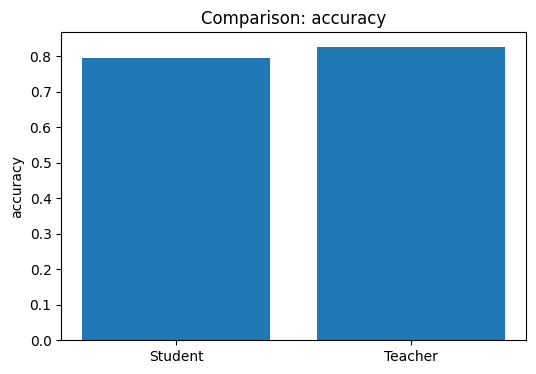

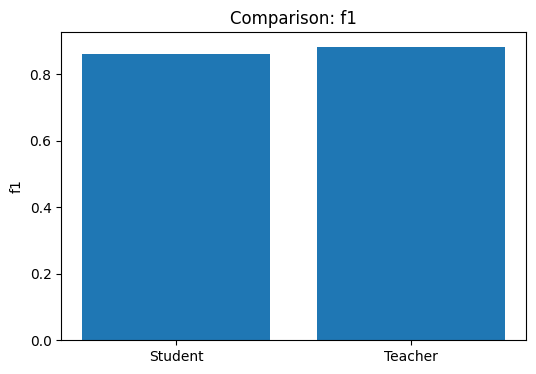

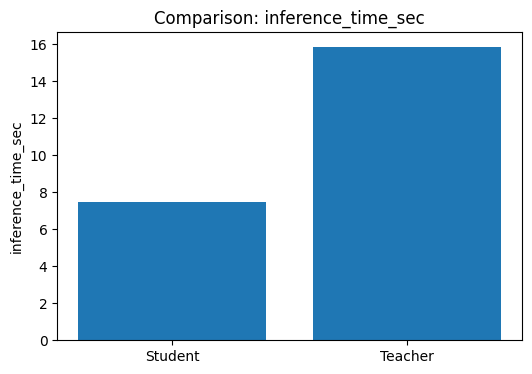

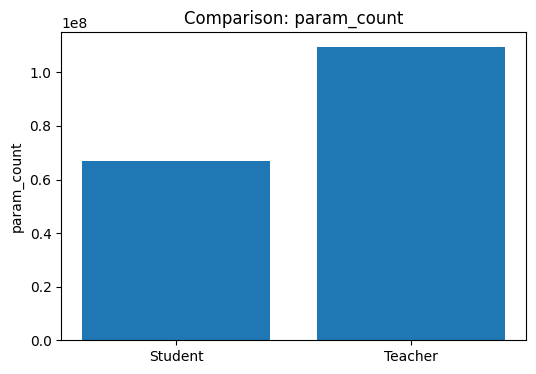

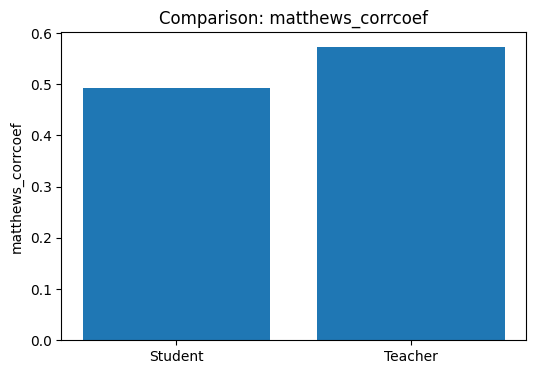

In [31]:
import matplotlib.pyplot as plt
import os


plots_dir = "/content/drive/MyDrive/CS4782FinalProject/artifacts/cola-used/plots"
os.makedirs(plots_dir, exist_ok=True)


metrics = ["accuracy", "f1", "inference_time_sec", "param_count", "matthews_corrcoef"]

for metric in metrics:
    plt.figure(figsize=(6, 4))
    plt.bar(comparison_df["Model"], comparison_df[metric])
    plt.title(f"Comparison: {metric}")
    plt.ylabel(metric)
    plt.show()

    save_path = os.path.join(plots_dir, f"{metric}_comparison.png")
    plt.savefig(save_path)

    plt.close()

In [32]:
print(student_results)
print(teacher_results)

{'accuracy': 0.7957813998082455, 'precision': 0.812039312039312, 'recall': 0.9167822468793343, 'f1': 0.8612377850162867, 'confusion_matrix': array([[169, 153],
       [ 60, 661]]), 'matthews_corrcoef': np.float64(0.49285731840923963), 'inference_time_sec': 7.49695086479187, 'param_count': 66955010}
{'accuracy': 0.8264621284755513, 'precision': 0.8292682926829268, 'recall': 0.9431345353675451, 'f1': 0.8825438027255029, 'confusion_matrix': array([[182, 140],
       [ 41, 680]]), 'matthews_corrcoef': np.float64(0.5727969336224868), 'inference_time_sec': 15.85075855255127, 'param_count': 109483778}
